# LeetCode Recommender Simulation Analysis

This notebook analyzes the results from simulating different agent profiles (Beginner, Moderate, Expert) interacting with the LeetCode recommender system versus a random baseline.

# 1. Setup: Import libraries and define basic parameters

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

In [11]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6) # Default figure size

# Define base directory and file pattern
LOG_DIR = '.' # Assuming logs are in the same directory as the notebook
FILE_PATTERN = './test1/simulation_log_*.csv'

# Define known profiles and types for ordering/coloring plots
PROFILES = ['Freshman', 'Sophomore', 'Senior']
AGENT_TYPES = ['recommender', 'random_baseline']

try:
    # If simulation.py is in the same directory or path
    from simulation import AGENT_CATEGORIES
    SKILL_COLS = [f'agent_skill_{cat.replace(" ", "_")}' for cat in AGENT_CATEGORIES]
except ImportError:
    print("Warning: Could not import AGENT_CATEGORIES. Manually define or ensure simulation.py is accessible.")
    # Manually define if needed, ensure it matches the columns in your CSV
    AGENT_CATEGORIES = [
        "Arrays and Hashing", "Two Pointers", "Stack", "Sliding Window", "Binary Search",
        "Linked List", "Tree", "Tries", "Heap / Priority Queue", "Backtracking",
        "Intervals", "Greedy", "Graph", "Graph2", "1DDP", "2DDP",
        "Bit Manipulation", "Math"
    ] # Make sure this list matches your actual categories used in logging
    SKILL_COLS = [f'agent_skill_{cat.replace(" ", "_")}' for cat in AGENT_CATEGORIES]

## 2. Load Data

Find all simulation log files and combine them into a single DataFrame.

In [12]:
all_files = glob.glob(os.path.join(LOG_DIR, FILE_PATTERN))

if not all_files:
    print(f"Error: No files found matching pattern '{FILE_PATTERN}' in directory '{LOG_DIR}'")
    # Stop execution or handle appropriately
    raise FileNotFoundError("No simulation log files found.")

li = []
for filename in all_files:
    print(f"Loading: {filename}")
    try:
        df_temp = pd.read_csv(filename)
        # Add filename parts as columns if not present (e.g., if run_all_simulations didn't exist yet)
        if 'agent_profile' not in df_temp.columns:
             # Example: Extract from filename 'simulation_log_Beginner_recommender.csv'
             parts = os.path.basename(filename).replace('simulation_log_', '').replace('.csv', '').split('_')
             if len(parts) >= 2:
                 df_temp['agent_profile'] = parts[0]
                 df_temp['agent_type'] = "_".join(parts[1:]) # Handle multi-word types if needed
        li.append(df_temp)
    except Exception as e:
        print(f"Error loading {filename}: {e}")


if not li:
     raise ValueError("No data loaded successfully.")

df = pd.concat(li, axis=0, ignore_index=True)

print(f"\nLoaded data shape: {df.shape}")
print("\nData types:")
print(df.dtypes)
print("\nFirst 5 rows:")
print(df.head())
print("\nAgent Profiles and Types Found:")
print(df[['agent_profile', 'agent_type']].value_counts())


Loading: ././test1/simulation_log_Sophomore_random.csv
Loading: ././test1/simulation_log_Senior_random.csv
Loading: ././test1/simulation_log_Freshman_random.csv
Loading: ././test1/simulation_log_Senior_recommender.csv
Loading: ././test1/simulation_log_Sophomore_recommender.csv
Loading: ././test1/simulation_log_Freshman_recommender.csv

Loaded data shape: (1200, 51)

Data types:
step                                          int64
agent_id                                      int64
agent_profile                                object
agent_type                                   object
problem_id                                    int64
problem_title                                object
problem_category                             object
problem_difficulty                           object
agent_skill_before                          float64
solved                                         bool
time_taken                                  float64
agent_skill_after                           flo

## 3. Data Cleaning / Preparation

- Convert columns to appropriate types if needed.
- Calculate average skill across all categories for each step.
- Calculate cumulative problems solved.

In [13]:
if df['solved'].dtype != bool:
    df['solved'] = df['solved'].astype(bool)

# Calculate average agent skill per row
# Ensure all skill columns exist before attempting to calculate mean
existing_skill_cols = [col for col in SKILL_COLS if col in df.columns]
if not existing_skill_cols:
     print("Warning: No skill columns found in the DataFrame. Skipping average skill calculation.")
     df['average_skill'] = np.nan
else:
     if len(existing_skill_cols) < len(SKILL_COLS):
          print(f"Warning: Missing some skill columns. Calculating average based on found columns: {existing_skill_cols}")
     df['average_skill'] = df[existing_skill_cols].mean(axis=1)

# Calculate cumulative solved count per agent run
# Group by agent_id, profile, type and then calculate cumulative sum on 'solved'
df['cumulative_solved'] = df.sort_values(by='step').groupby(['agent_id', 'agent_profile', 'agent_type'])['solved'].cumsum()

print("\nDataFrame with calculated columns:")
print(df[['step', 'agent_profile', 'agent_type', 'solved', 'average_skill', 'cumulative_solved']].head())


DataFrame with calculated columns:
   step agent_profile       agent_type  solved  average_skill  \
0     1     Sophomore  random_baseline   False       0.272222   
1     2     Sophomore  random_baseline   False       0.272222   
2     3     Sophomore  random_baseline   False       0.272222   
3     4     Sophomore  random_baseline   False       0.272222   
4     5     Sophomore  random_baseline   False       0.272222   

   cumulative_solved  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  


## 4. Analysis & Visualization

### 4.1 Overall Performance Comparison

<Figure size 1000x600 with 0 Axes>

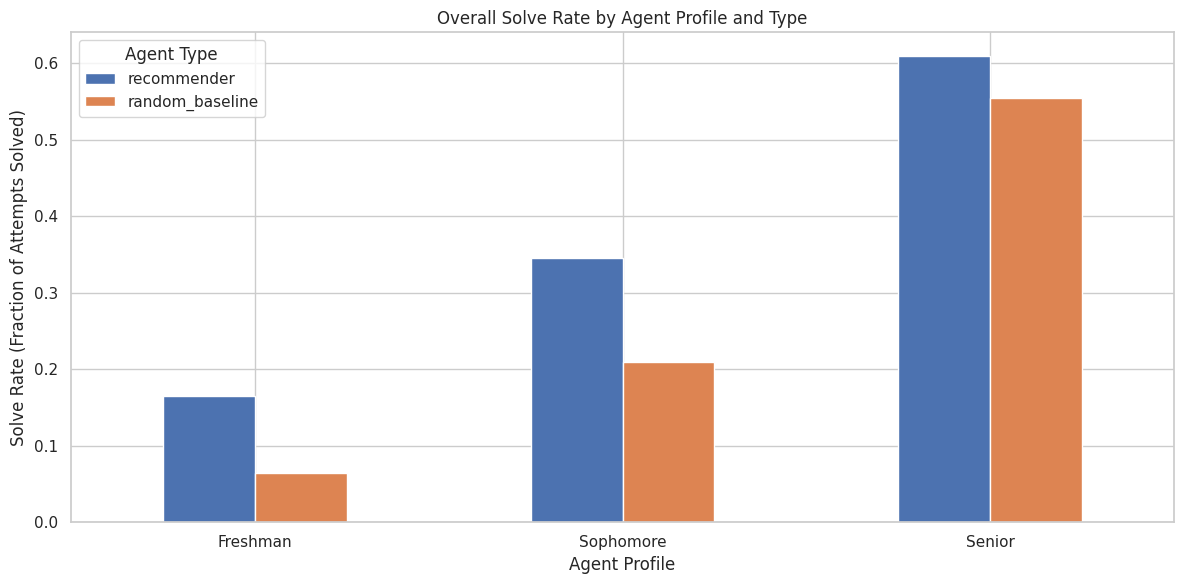

In [14]:
plt.figure(figsize=(10, 6))
solve_rate_summary = df.groupby(['agent_profile', 'agent_type'])['solved'].mean().unstack()
solve_rate_summary = solve_rate_summary.reindex(index=PROFILES, columns=AGENT_TYPES) # Ensure consistent order
solve_rate_summary.plot(kind='bar', rot=0)
plt.title('Overall Solve Rate by Agent Profile and Type')
plt.ylabel('Solve Rate (Fraction of Attempts Solved)')
plt.xlabel('Agent Profile')
plt.legend(title='Agent Type')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

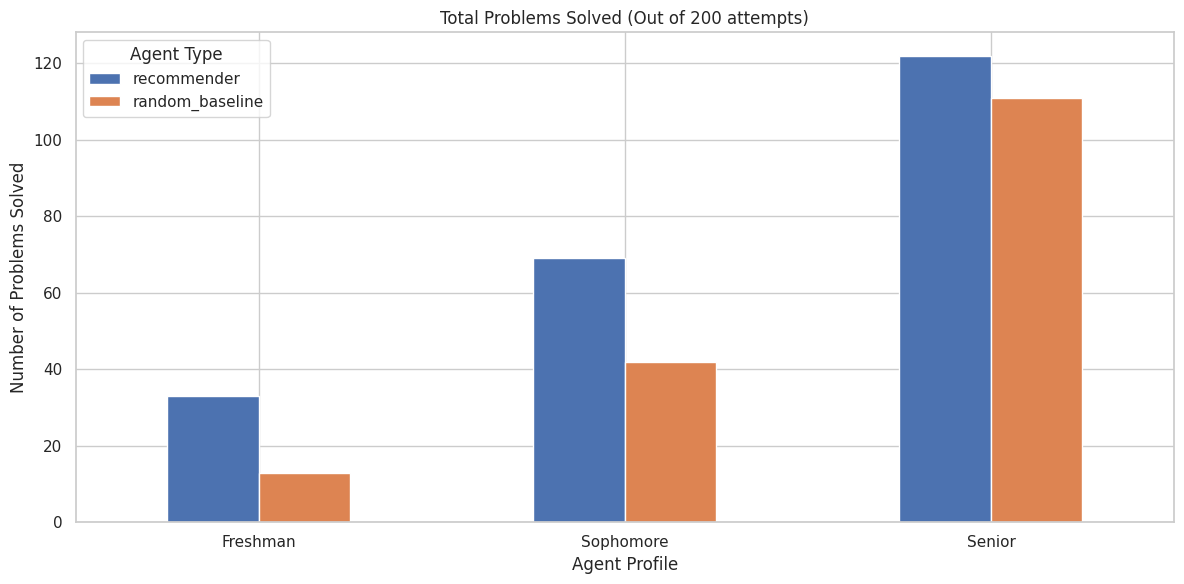

In [15]:
plt.figure(figsize=(10, 6))
total_solved_summary = df.groupby(['agent_profile', 'agent_type'])['solved'].sum().unstack()
total_solved_summary = total_solved_summary.reindex(index=PROFILES, columns=AGENT_TYPES)
total_solved_summary.plot(kind='bar', rot=0)
plt.title(f'Total Problems Solved (Out of {df["step"].max()} attempts)')
plt.ylabel('Number of Problems Solved')
plt.xlabel('Agent Profile')
plt.legend(title='Agent Type')
plt.tight_layout()
plt.show()

### 4.2 Learning Progression

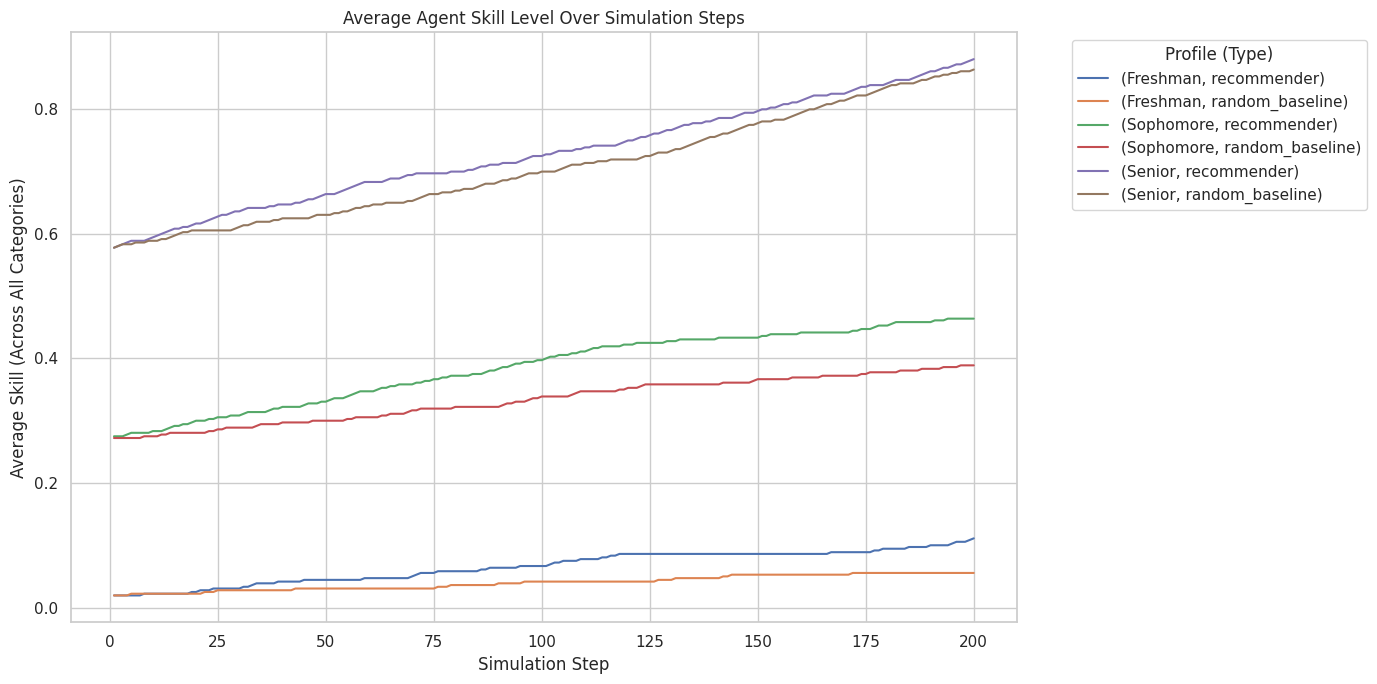

In [16]:
# Average Skill Level Over Time
plt.figure(figsize=(14, 7))
avg_skill_over_time = df.groupby(['step', 'agent_profile', 'agent_type'])['average_skill'].mean().unstack(['agent_profile', 'agent_type'])
# Reorder columns for better legend readability
avg_skill_over_time = avg_skill_over_time.reindex(columns=pd.MultiIndex.from_product([PROFILES, AGENT_TYPES], names=['agent_profile', 'agent_type']))

avg_skill_over_time.plot(ax=plt.gca()) # Plot on the current axes
plt.title('Average Agent Skill Level Over Simulation Steps')
plt.ylabel('Average Skill (Across All Categories)')
plt.xlabel('Simulation Step')
plt.legend(title='Profile (Type)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

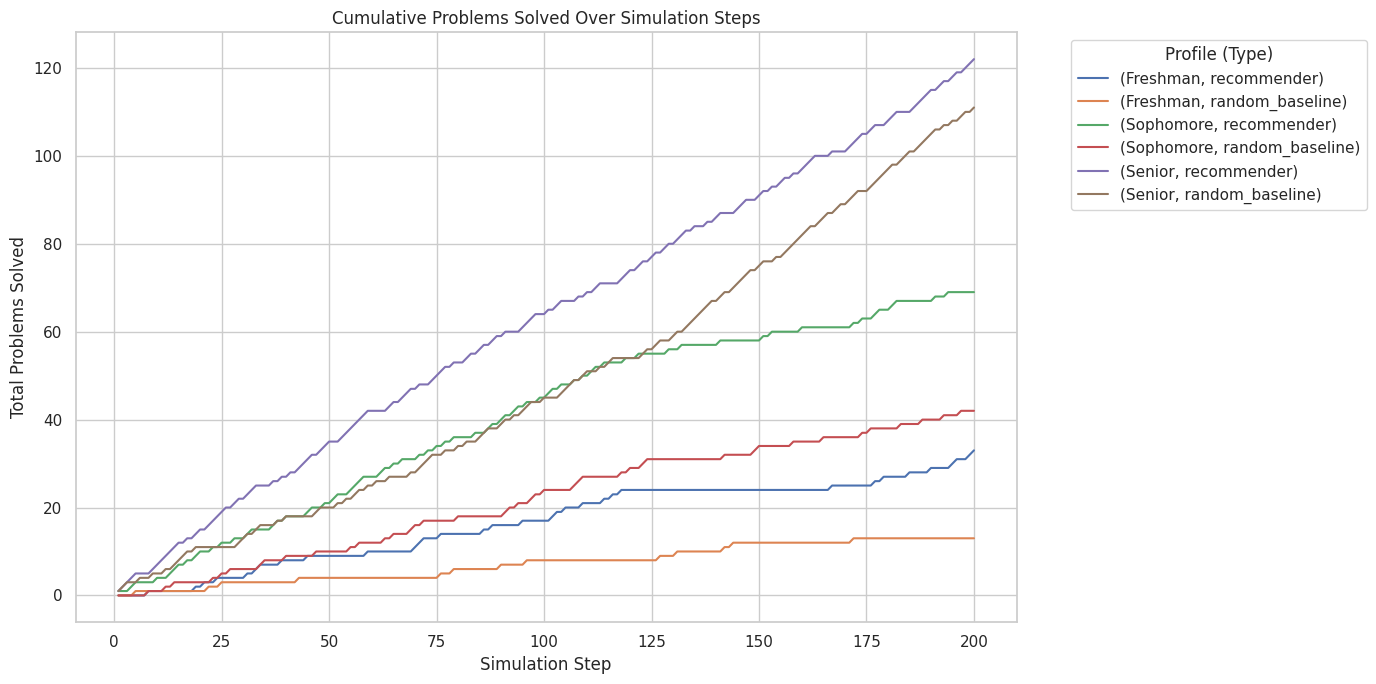

In [17]:
plt.figure(figsize=(14, 7))
cumulative_solved_over_time = df.groupby(['step', 'agent_profile', 'agent_type'])['cumulative_solved'].mean().unstack(['agent_profile', 'agent_type'])
cumulative_solved_over_time = cumulative_solved_over_time.reindex(columns=pd.MultiIndex.from_product([PROFILES, AGENT_TYPES], names=['agent_profile', 'agent_type']))

cumulative_solved_over_time.plot(ax=plt.gca())
plt.title('Cumulative Problems Solved Over Simulation Steps')
plt.ylabel('Total Problems Solved')
plt.xlabel('Simulation Step')
plt.legend(title='Profile (Type)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

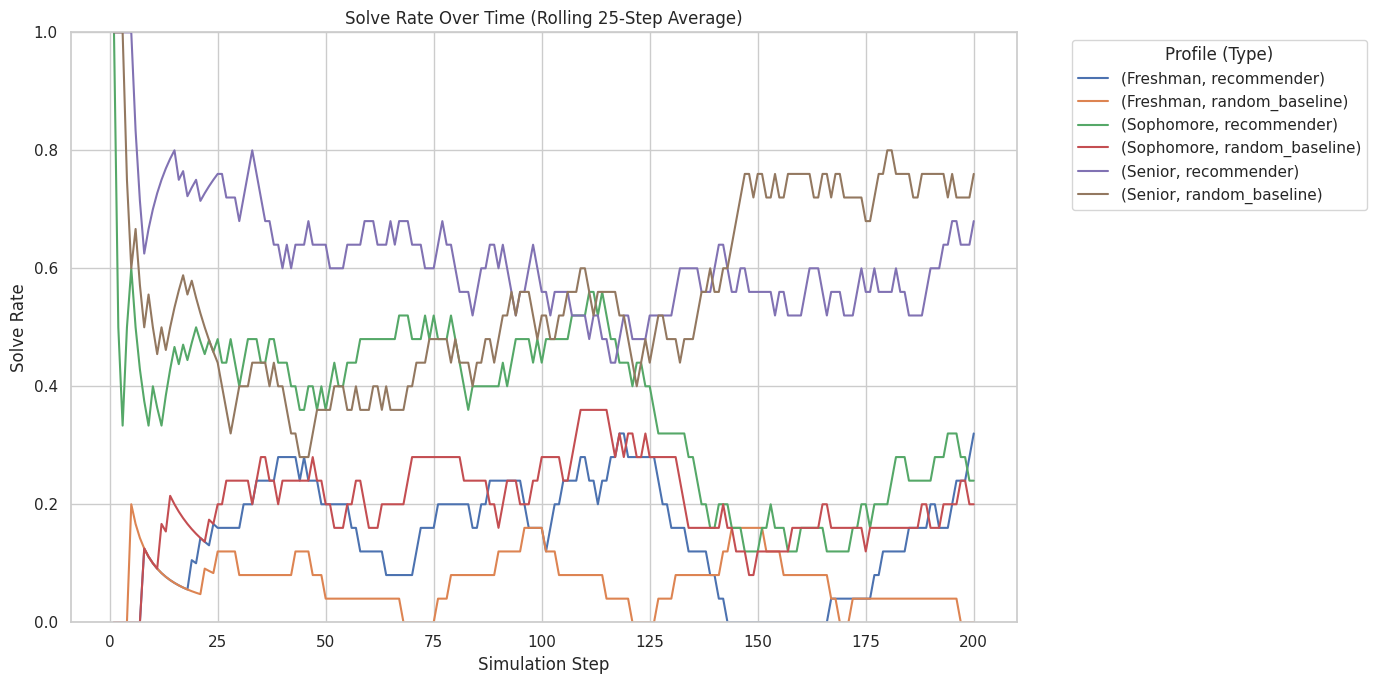

In [18]:
WINDOW_SIZE = 25 # Adjust as needed
df['solve_rate_rolling'] = df.sort_values(by='step').groupby(['agent_id', 'agent_profile', 'agent_type'])['solved'] \
                             .rolling(window=WINDOW_SIZE, min_periods=1).mean().reset_index(level=[0,1,2], drop=True)

plt.figure(figsize=(14, 7))
rolling_solve_rate = df.groupby(['step', 'agent_profile', 'agent_type'])['solve_rate_rolling'].mean().unstack(['agent_profile', 'agent_type'])
rolling_solve_rate = rolling_solve_rate.reindex(columns=pd.MultiIndex.from_product([PROFILES, AGENT_TYPES], names=['agent_profile', 'agent_type']))

rolling_solve_rate.plot(ax=plt.gca())
plt.title(f'Solve Rate Over Time (Rolling {WINDOW_SIZE}-Step Average)')
plt.ylabel('Solve Rate')
plt.xlabel('Simulation Step')
plt.ylim(0, 1) # Rate is between 0 and 1
plt.legend(title='Profile (Type)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### 4.3 Problem Selection Patterns

<Figure size 1200x700 with 0 Axes>

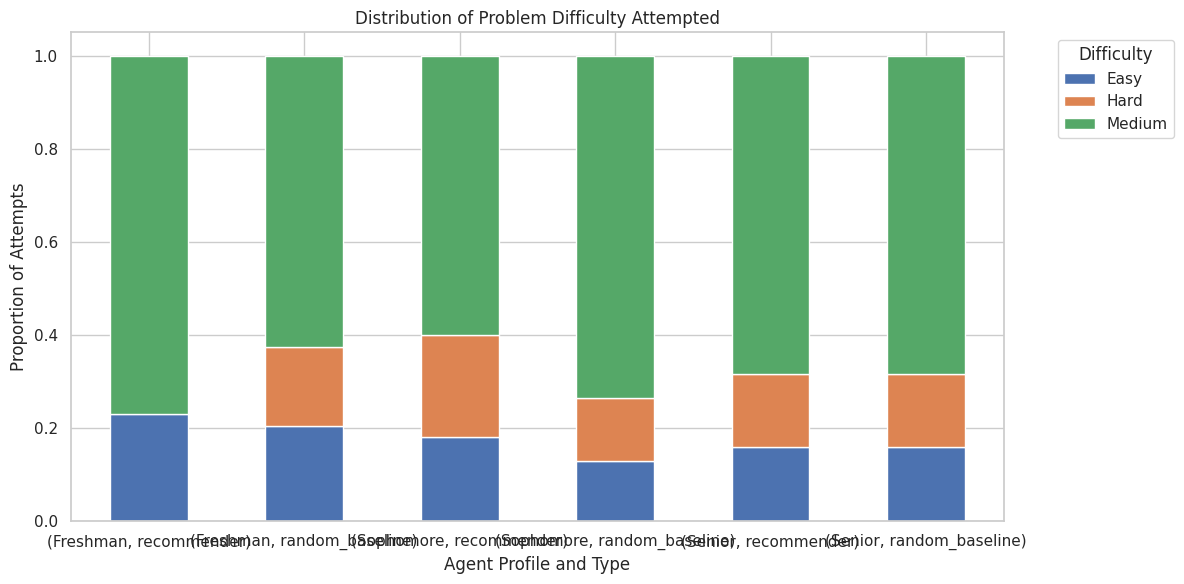

In [19]:
# Distribution of Problem Difficulty Attempted
plt.figure(figsize=(12, 7))
difficulty_counts = pd.crosstab([df['agent_profile'], df['agent_type']], df['problem_difficulty'], normalize='index')
difficulty_counts = difficulty_counts.reindex(index=pd.MultiIndex.from_product([PROFILES, AGENT_TYPES], names=['agent_profile', 'agent_type']))

difficulty_counts.plot(kind='bar', stacked=True, rot=0)
plt.title('Distribution of Problem Difficulty Attempted')
plt.ylabel('Proportion of Attempts')
plt.xlabel('Agent Profile and Type')
plt.legend(title='Difficulty', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 1500x800 with 0 Axes>

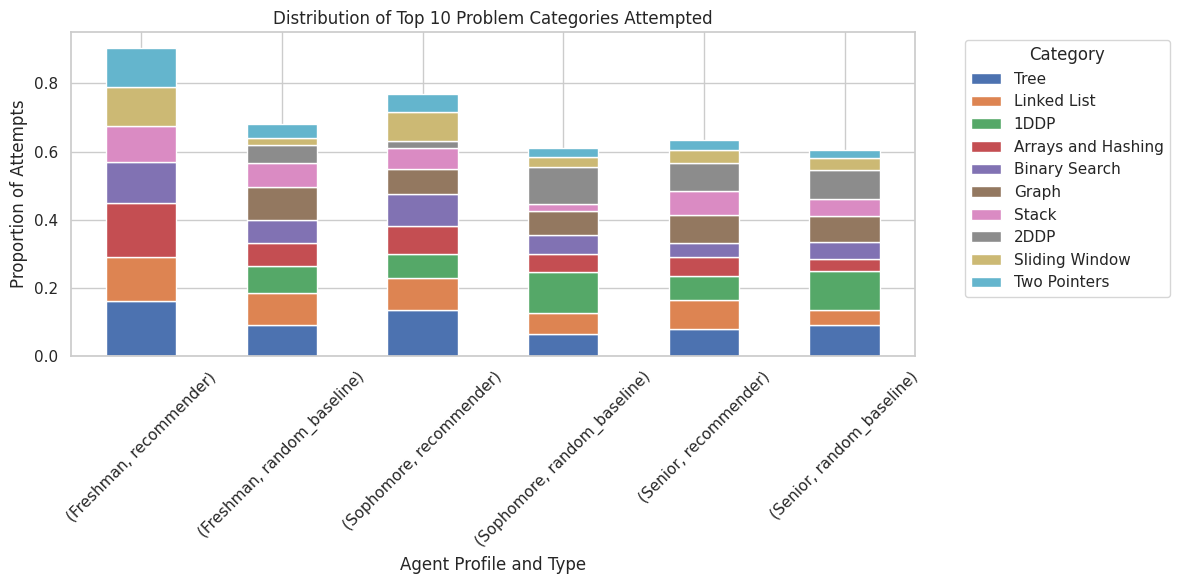


Full Category Distribution (Proportions):
problem_category                1DDP   2DDP  Arrays and Hashing  Backtracking  \
agent_profile agent_type                                                        
Freshman      recommender      0.000  0.000               0.160         0.000   
              random_baseline  0.080  0.055               0.065         0.025   
Sophomore     recommender      0.070  0.020               0.080         0.045   
              random_baseline  0.120  0.110               0.055         0.060   
Senior        recommender      0.070  0.080               0.055         0.050   
              random_baseline  0.115  0.085               0.035         0.075   

problem_category               Binary Search  Bit Manipulation  Graph  Graph2  \
agent_profile agent_type                                                        
Freshman      recommender              0.120             0.000  0.000   0.000   
              random_baseline          0.070             0.040  0

In [20]:
# Distribution of Problem Categories Attempted (May be too cluttered - consider top N or grouping)
plt.figure(figsize=(15, 8))
# Use normalize='index' for proportion within each agent group
category_counts = pd.crosstab([df['agent_profile'], df['agent_type']], df['problem_category'], normalize='index')
category_counts = category_counts.reindex(index=pd.MultiIndex.from_product([PROFILES, AGENT_TYPES], names=['agent_profile', 'agent_type']))

# Plotting all categories might be too much, consider plotting top N or just showing the table
# Example: Plot top 10 most attempted categories overall
top_categories = df['problem_category'].value_counts().nlargest(10).index
category_counts[top_categories].plot(kind='bar', stacked=True, rot=45) # Use rot=45 for readability
plt.title('Distribution of Top 10 Problem Categories Attempted')
plt.ylabel('Proportion of Attempts')
plt.xlabel('Agent Profile and Type')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("\nFull Category Distribution (Proportions):")
print(category_counts)


## Conclusions

**Summary:**

With the longer simulation duration(1000 steps):

*   **Beginner Agents:** The recommender provides a **negligible benefit** over random. Both methods allow the agent to progress significantly.
*   **Moderate Agents:** The recommender demonstrates a **clear and substantial advantage** in efficiency (solve rate, total problems solved) over the random baseline, even though the final skill level ended up fractionally *lower*.
*   **Expert Agents:** Performance is now **virtually identical** between the recommender and random baseline. Both allow the expert to reach maximum average skill within 1000 steps.

**Detailed Analysis per Profile:**

1.  **Beginner Profile:**
    *   **Performance:** Recommender (13.1% solve rate, 131 solved) vs. Random (12.8%, 128 solved). The tiny advantage seen at 200 steps persists but remains marginal.
    *   **Skill:** Recommender (Final 0.464, Change +0.364) vs. Random (Final 0.456, Change +0.356). Again, a very slight edge for the recommender. Both agents reached a "moderate" skill level by the end.
    *   **Difficulty:** Both Recommender (6.9% E, 63.6% M, 29.5% H) and Random (6.9% E, 68.8% M, 24.3% H) gave very few Easy problems overall. The recommender assigned slightly *more* Hard problems than random. This suggests that as the Beginner's skill increased over the 1000 steps, the recommender adapted and started pushing harder problems, similar to the random baseline. The initial benefit of focusing on Easy (seen in the 200-step run) becomes less relevant over the long haul.
    *   *Interpretation:* The recommender doesn't offer a significant long-term advantage for beginners. Both approaches eventually expose the agent to harder problems, leading to similar outcomes.

2.  **Moderate Profile:**
    *   **Performance:** Recommender (64.9% solve rate, 649 solved) vs. Random (55.6%, 556 solved). **This is a strong win for the recommender.** It enabled the agent to solve almost 100 more problems with a significantly higher success rate.
    *   **Skill:** Recommender (Final 0.978, Change +0.628) vs. Random (Final 0.983, Change +0.633). Interestingly, the *random* baseline resulted in slightly higher final skill and skill change.
    *   **Difficulty:** Recommender (15.0% E, 66.6% M, 18.4% H) vs. Random (14.9% E, 59.3% M, **25.8% H**). This explains the skill difference: the random baseline pushed significantly *more* Hard problems. While this led to a lower solve rate, encountering and eventually solving those harder problems resulted in slightly higher final skill.
    *   *Interpretation:* The recommender appears to be more *efficient* for Moderate users. It guides them through the bulk of the material (Medium problems) more effectively, leading to higher throughput (more problems solved). However, the random baseline, by chance, provided more difficult (Hard) problems, leading to a marginally higher peak skill level despite lower overall efficiency. This highlights a potential trade-off in the recommender's strategy.

3.  **Expert Profile:**
    *   **Performance:** Recommender (81.8% solve rate, 818 solved) vs. Random (81.7%, 817 solved). **Performance is now identical.** The deficit seen in the 200-step run has vanished.
    *   **Skill:** Recommender (Final 1.000, Change +0.400) vs. Random (Final 1.000, Change +0.400). Both agents reached the maximum possible average skill level (1.0) and had identical gains.
    *   **Difficulty:** Recommender (16.5% E, 66.7% M, 16.8% H) vs. Random (16.2% E, 66.9% M, 16.9% H). The distributions are **virtually identical**.
    *   *Interpretation:* Over 1000 steps, both methods are sufficient for an expert to master the content according to the simulation's skill metric. However, the recommender *still* isn't demonstrating intelligent targeting; it's simply matching the random distribution. It's not accelerating the expert's path to mastery by focusing on the most challenging remaining problems (presumably Hard ones).

**Key Takeaways & Revised Conclusions:**

1.  **Strongest Benefit for Moderate:** The recommender's primary value lies in efficiently guiding users through the intermediate stages of learning (the Moderate profile), significantly boosting the number of problems they solve successfully compared to random chance.
2.  **Beginner/Expert Indifference:** In the long run, the recommender offers little to no advantage over random selection for absolute beginners or for experts who will eventually reach mastery regardless.
3.  **Adaptation Confirmed:** The recommender *does* adapt the difficulty over time (Beginners eventually get harder problems), but this adaptation doesn't necessarily lead to superior long-term outcomes compared to random for Beginners or Experts.
4.  **Expert Targeting Still Weak:** The core issue remains: the recommender doesn't identify or prioritize the most challenging content (Hard problems) for high-skill users. It defaults to the database's natural distribution (likely Medium-heavy).
5.  **Efficiency vs. Peak Skill:** The Moderate profile results show the recommender optimizes for solve rate/throughput, potentially at the cost of pushing slightly less challenging content than pure random chance might *sometimes* provide (leading to Random's slightly higher final skill in that specific case). Is maximizing problems solved or reaching the absolute skill ceiling faster the primary goal?

**Recommendations:**

1.  **Prioritize Expert Strategy:** The biggest opportunity for improvement is making the recommender *smarter* for Experts. It needs logic to recognize high skill (either overall or per-category) and strongly bias towards unsolved Hard problems in relevant categories.
2.  **Refine Moderate Strategy:** Consider if the trade-off for Moderate users (high throughput vs. fractionally lower peak skill compared to random) is desirable. If pushing towards peak skill is important, the recommender could become more aggressive with Hard problems once a user's skill in a category surpasses a certain threshold (e.g., > 0.7).
3.  **Review SM-2 Interaction:** How does the SM-2 review schedule influence recommendations? Are experts getting stuck reviewing Medium problems they already know well instead of being pushed towards new Hard ones? Ensure `get_due_problems` doesn't overly dominate the selection process for high-skill users who might benefit more from new challenges. The `interleaving` function might need adjustment to weigh new unsolved problems more heavily than due reviews for experts.

This longer simulation provides valuable insights. The recommender is clearly beneficial during the main learning phase (Moderate) but needs significant work to provide value at the start and, more critically, at the end stages of learning.